## MeLi Data Challenge 2019

This notebook is part of a curated version of my original solution for the MeLi Data Challenge hosted by [Mercado Libre](https://www.mercadolibre.com/) in 2019

The goal of this first challenge was to create a model that would classify items into categories based solely on the item’s title. 

This title is a free text input from the seller that would become the header of the listings.

<div class="alert alert-block alert-info">
<b>Note</b> <p>Only 10% of the data is used in the notebooks to improve the experience.</p>
    <p>Also, data is not being splitted by language in this notebooks for simplicity reasons only</p>
    <p>In the scripted version, 100% of the data is used to improve results</p>
</div>

### 2 - Train Model

In this notebook, we train a CNN using all the data created in the previous steps

### Import libraries

In [67]:
import pandas as pd
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
import copy
from tensorflow.keras.layers import Input, Dense, Embedding, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout, concatenate, Bidirectional, LSTM, MaxPooling1D, Activation, SpatialDropout1D
from tensorflow.keras.layers import Reshape, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from statics import *
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, classification_report
import csv

### Load data

In [19]:
df = pd.read_pickle('./data/df.pkl')
len_sent = joblib.load('./data/len_sent.h5')

### Encode cateogories and save the references

In [20]:
nb_classes = len(np.unique(df['category']))
labels, levels = pd.factorize(df['category'])        
joblib.dump(nb_classes,'./data/nb_classes')
joblib.dump(levels,'./data/levels')

['./data/levels']

### Split data 

We now split data into train and validation
<div class="alert alert-block alert-info">
<b>Note</b> <p>In <b>2- PreProcess</b> we also splitted the data in order to have a testing set</p>
</div>

In [21]:
train_df, val_df = train_test_split(df,test_size=0.1, stratify=df['category'])

### Data preparation steps
Here, we extract the values from the dataframes and generate the necessary encoded labels

In [22]:
y = copy.deepcopy(train_df['category'].values)
x = copy.deepcopy(train_df['input_data'].values)
y_val_in = copy.deepcopy(val_df['category'].values)
x_val_in = copy.deepcopy(val_df['input_data'].values)

In [23]:
x = np.stack(x)
x_val = np.stack(x_val_in)

In [24]:
def indices_to_one_hot(data, nb_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = np.array(data, dtype=np.int16).reshape(-1)
    return np.eye(nb_classes,dtype=np.int8)[targets]

In [25]:
y = [np.where(levels==i)[0][0] for i in y]
y_val = [np.where(levels==i)[0][0] for i in y_val_in]

In [26]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight ='balanced',
                                                 classes = np.unique(y),
                                                 y = y)
class_weights = dict(zip(np.unique(y), class_weights))

In [27]:
y = indices_to_one_hot(y, nb_classes)
y_val = indices_to_one_hot(y_val, nb_classes)

### Define model

In [28]:
output_shape = y_val.shape[1]

In [29]:
def cnn_model(input_dim, output_shape, path=''):
    
    weights = np.load(open(path+'/embeddings.npz', 'rb'))
    embedding_dim = weights.shape[1]
    
    inputs = Input(shape=(input_dim,), dtype='int32')
    
    embedding = Embedding(output_dim=weights.shape[1], input_dim=weights.shape[0], input_length=input_dim,
                              weights=[weights], trainable=True)(inputs)
                              
    spatial_dropout = SpatialDropout1D(0.5)(embedding)
        
    reshape = Reshape((input_dim, embedding_dim, 1))(spatial_dropout)

    conv_0 = Conv2D(num_filters, (filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal',
                           activation='sigmoid', data_format='channels_last')(reshape)
    conv_1 = Conv2D(num_filters, (filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal',
                           activation='sigmoid', data_format='channels_last')(reshape)
    conv_2 = Conv2D(num_filters, (filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal',
                           activation='sigmoid', data_format='channels_last')(reshape)
    conv_3 = Conv2D(num_filters, (filter_sizes[3], embedding_dim), padding='valid', kernel_initializer='normal',
                       activation='sigmoid', data_format='channels_last')(reshape)


    maxpool_0 = MaxPooling2D(pool_size=(input_dim - filter_sizes[0] + 1, 1), strides=(1, 1),
                             padding='valid', data_format='channels_last')(conv_0)
    maxpool_1 = MaxPooling2D(pool_size=(input_dim - filter_sizes[1] + 1, 1), strides=(1, 1),
                             padding='valid', data_format='channels_last')(conv_1)
    maxpool_2 = MaxPooling2D(pool_size=(input_dim - filter_sizes[2] + 1, 1), strides=(1, 1),
                             padding='valid', data_format='channels_last')(conv_2)
    maxpool_3 = MaxPooling2D(pool_size=(input_dim - filter_sizes[3] + 1, 1), strides=(1, 1),
                             padding='valid', data_format='channels_last')(conv_3)

    merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2, maxpool_3], axis=1)
    
    flatten = Flatten()(merged_tensor)
    
    #dense1 = Dense(units=output_dim, kernel_regularizer=regularizers.l2(0.01))(flatten)
    dense1 = Dense(units=output_dim)(flatten)
    #dense1 = BatchNormalization()(dense1)
    dense1 = Activation('relu')(dense1)
    dense1 = Dropout(drop)(dense1)

    #dense2 = Dense(units=output_dim, kernel_regularizer=regularizers.l2(0.01))(dense1)
    dense2 = Dense(units=output_dim)(dense1)
    #dense2 = BatchNormalization()(dense2)
    dense2 = Activation('relu')(dense2)
    dense2 = Dropout(drop)(dense2)

    #dense2 = Dense(units=output_dim, activation='relu')(dense1)
    #dense3 = Dense(units=output_dim, activation='relu')(dense2)
    output = Dense(units=output_shape)(dense1)
    #output = BatchNormalization()(output)
    output = Activation('softmax')(output)


    #output = Dense(units=output_shape, activation='softmax')(normalized_1)
    
    model = Model(inputs=inputs, outputs=output)
    
    return model

In [30]:
model = cnn_model(len_sent, output_shape, path='data')

In [31]:
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.save('./data/my_model.h5')

In [32]:
checkpoint = ModelCheckpoint('./data/weights.hdf5', monitor='val_acc', verbose=2,
                                             save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss',patience=6, verbose = 1)
reduceLR = ReduceLROnPlateau(monitor='val_loss',factor=0.33,patience=2,verbose = 1)

In [33]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 23)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 23, 300)      1972500     input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 23, 300)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 23, 300, 1)   0           spatial_dropout1d_1[0][0]        
_______________________________________________________________________________________

In [34]:
history = model.fit(x, y, batch_size=batch_size, epochs=nb_epoch, verbose=1,
                              callbacks=[checkpoint, early_stopping, reduceLR], validation_data=(x_val, y_val), class_weight=class_weights)

Epoch 1/50
317/317 [==============================] - 36s 112ms/step - loss: 7.3717 - accuracy: 7.9633e-04 - val_loss: 7.3492 - val_accuracy: 0.0013
Epoch 2/50
317/317 [==============================] - 35s 111ms/step - loss: 7.3536 - accuracy: 8.0867e-04 - val_loss: 7.3501 - val_accuracy: 0.0012
Epoch 3/50
317/317 [==============================] - 35s 111ms/step - loss: 7.3533 - accuracy: 0.0011 - val_loss: 7.3488 - val_accuracy: 0.0017
Epoch 4/50
317/317 [==============================] - 35s 111ms/step - loss: 7.3515 - accuracy: 0.0015 - val_loss: 7.3425 - val_accuracy: 0.0030
Epoch 5/50
317/317 [==============================] - 35s 111ms/step - loss: 7.3432 - accuracy: 0.0019 - val_loss: 7.3098 - val_accuracy: 0.0046
Epoch 6/50
317/317 [==============================] - 35s 111ms/step - loss: 7.2971 - accuracy: 0.0024 - val_loss: 7.0960 - val_accuracy: 0.0034
Epoch 7/50
317/317 [==============================] - 35s 111ms/step - loss: 7.1135 - accuracy: 0.0028 - val_loss: 6.7298 

Epoch 28/50
317/317 [==============================] - 35s 111ms/step - loss: 4.0686 - accuracy: 0.2422 - val_loss: 3.0508 - val_accuracy: 0.4853
Epoch 29/50
317/317 [==============================] - 35s 111ms/step - loss: 3.9429 - accuracy: 0.2617 - val_loss: 2.9443 - val_accuracy: 0.5034
Epoch 30/50
317/317 [==============================] - 35s 111ms/step - loss: 3.8425 - accuracy: 0.2829 - val_loss: 2.8417 - val_accuracy: 0.5232
Epoch 31/50
317/317 [==============================] - 35s 111ms/step - loss: 3.7416 - accuracy: 0.3007 - val_loss: 2.7534 - val_accuracy: 0.5316
Epoch 32/50
317/317 [==============================] - 35s 111ms/step - loss: 3.6304 - accuracy: 0.3200 - val_loss: 2.6705 - val_accuracy: 0.5471
Epoch 33/50
317/317 [==============================] - 35s 111ms/step - loss: 3.5444 - accuracy: 0.3392 - val_loss: 2.5819 - val_accuracy: 0.5579
Epoch 34/50
317/317 [==============================] - 35s 111ms/step - loss: 3.4504 - accuracy: 0.3574 - val_loss: 2.5070 -

### Plot training

In [47]:
def plot_history(history, pref=None):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

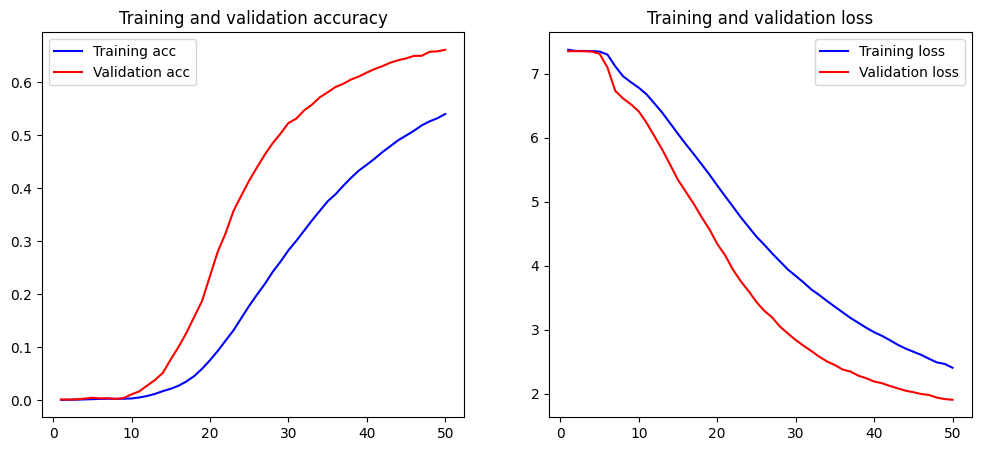

In [50]:
plot_history(history)

### Calculat BACC on Test Set

The metric used for evaluation in the challenge was Balanced Accuracy

In [52]:
df_test = pd.read_pickle('./data/df_test.pkl')
xt = np.stack(df_test['input_data'])
outputs = model.predict(xt)

In [53]:
yt = [np.where(levels==i)[0][0] for i in df_test['category']]

In [54]:
yt = np.array(yt)

In [55]:
yt = indices_to_one_hot(yt, nb_classes)

In [57]:
bacc = balanced_accuracy_score(np.argmax(yt, axis=1), np.argmax(outputs, axis=1))

c:\users\basla\documents\projects\bleandblog\bleandblog_posts\meli2019\meli2019\lib\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [62]:
print(f"Bacc: {round(bacc*100, 2)}%")

Bacc: 60.94%


### Generate output file with predictions

In order to analyze how each class is performing, we print in a csv file some detailed information

This was used mostly to identify wordings specific to some classes that were replaced with generic tags using ReGex

In [70]:
def output_csv(y_true,y_pred,  orig_test, pad_test, language='spanish', path='', bacc = 0):
    levels = joblib.load('./data/levels')
    csv_file = open('./data/Output_CNN.csv', 'w', newline='', encoding='utf-8')
    writer = csv.writer(csv_file)
    writer.writerow(
        ['Original','Padded','Human', 'Pred', 'Prob', 'BACC'])
    ix = 0
    cat_true = []
    cat_pred = []
    first = 0
    for y,h,o,p in zip(y_true,y_pred,orig_test, pad_test):
        cat_true.append(levels[np.argmax(y)])
        cat_pred.append(levels[np.argmax(h)])
        if first == 0:
            writer.writerow([o,p,levels[np.argmax(y)], levels[np.argmax(h)],h[np.argmax(h)],bacc])
            first = 1
        else:
            writer.writerow([o,p,levels[np.argmax(y)], levels[np.argmax(h)], h[np.argmax(h)]])
    report = classification_report(cat_true, cat_pred, output_dict=True)
    df = pd.DataFrame(report)
    df.to_csv('./data/Report.csv')

    csv_file.close()

In [71]:
output_csv(yt,outputs, df_test['title'].values, df_test['sentences_padded'].values, bacc = bacc)

c:\users\basla\documents\projects\bleandblog\bleandblog_posts\meli2019\meli2019\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\basla\documents\projects\bleandblog\bleandblog_posts\meli2019\meli2019\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\basla\documents\projects\bleandblog\bleandblog_posts\meli2019\meli2019\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero

In [72]:
pd.read_csv('./data/Output_CNN.csv').head()

,Original,Padded,Human,Pred,Prob,BACC
0,Chomba Bodysuit Old Navy Pique Talle 12/18 Mes...,"['chomb', 'bodysuit', 'old', 'navy', 'piqu', '...",BABY_BODYSUITS,SWEATSHIRTS_AND_HOODIES,0.173360,0.609368
1,Portavaso Triades 169/c3 Fv Accesorio Baño Oferta,"['portavas', 'triad', '<number>', '<model>', '...",TOOTHBRUSH_HOLDERS,SHOWER_HEADS,0.256168,NaN
2,Placas De Aglomerado Recubierto Tipo Técnico X...,"['plac', 'aglomer', 'recubiert', 'tip', 'tecni...",DRYWALLS,DRYWALLS,0.101497,NaN
3,Tidog Mochila De Viaje Al Aire Libre Casual De...,"['tidog', 'mochil', 'viaj', 'al_air', 'libr', ...",TACTICAL_BAGS_AND_BACKPACKS,TACTICAL_BAGS_AND_BACKPACKS,0.378200,NaN
4,Tiara Chiquita Plateada Ideal 15 Años Modelo E...,"['tiar', 'chiquit', 'plat', 'ideal', '<number>...",HEADPIECES_TIARAS_AND_HEADBANDS,HEADPIECES_TIARAS_AND_HEADBANDS,0.701072,NaN
